<a href="https://colab.research.google.com/github/z-guard/analysis/blob/main/notebooks/childcare_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 子育てスコア
- input
    - public_school_score.csv
        - 幼稚園スコア
    - nursery_score.csv
        - 保育園スコア
        - 児童館スコア
- output
    - childcare_score.csv
        - 子育てスコア


In [1]:
!pip install -q japanize-matplotlib

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
DIR_NAME = '/content/drive/MyDrive/z-gard/data'

In [4]:
import os
import requests
import json
import pandas as pd
from urllib.parse import urlparse, quote
import io
import math
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [5]:
score_name = '子育てスコア'
output_score_file = 'childcare_score.csv'

### 人口マスタ

In [6]:
df_geo_master = pd.read_csv(os.path.join(DIR_NAME, 'geocoding.csv'))[['town_id', '市区町村名', '町名', '町丁目', '緯度', '経度']].set_index('town_id')
print(df_geo_master.shape)

(3145, 5)


### 学校スコア

In [7]:
df_school_score = pd.read_csv(os.path.join(DIR_NAME, 'public_school_score.csv'))[[
    'town_id', '幼稚園スコア',
]].set_index('town_id')
print(df_school_score.shape)

(3145, 1)


In [8]:
df_school_score.head()

,幼稚園スコア
town_id,
101003,2.60
101004,1.89
101005,1.88
101007,1.37
101008,2.18


### 保育園

In [9]:
df_nursery_score = pd.read_csv(os.path.join(DIR_NAME, 'nursery_score.csv'))[[
    'town_id', '保育園スコア', '児童館スコア'
]].set_index('town_id')
print(df_nursery_score.shape)

(3145, 2)


In [10]:
df_nursery_score.head()

,保育園スコア,児童館スコア
town_id,,
101003,0.09,0.17
101004,0.08,0.05
101005,0.10,0.05
101007,0.22,0.10
101008,0.31,0.38


In [11]:
def rank_score(sr_data):
    rank = sr_data.rank()
    rmax = rank.max()
    rmin = rank.min()
    max_val = 5
    x = (rank - rmin)/(rmax - rmin) * max_val
    return np.clip(x, 0, max_val)

### 子育てスコア

In [12]:
df_score = pd.concat([
    df_geo_master,
    df_school_score,
    df_nursery_score
], axis=1)
print(df_score.shape)
assert len(df_score) == len(df_geo_master)
df_geo_master = df_score

(3145, 8)


In [13]:
print(df_geo_master.shape)
df_geo_master.head()

(3145, 8)


,市区町村名,町名,町丁目,緯度,経度,幼稚園スコア,保育園スコア,児童館スコア
town_id,,,,,,,,
101003,千代田区,丸の内,丸の内１丁目,35.681560,139.767201,2.60,0.09,0.17
101004,千代田区,丸の内,丸の内２丁目,35.680022,139.763447,1.89,0.08,0.05
101005,千代田区,丸の内,丸の内３丁目,35.676952,139.763476,1.88,0.10,0.05
101007,千代田区,大手町,大手町１丁目,35.688069,139.763929,1.37,0.22,0.10
101008,千代田区,大手町,大手町２丁目,35.686301,139.768087,2.18,0.31,0.38


In [14]:
feature_list = {
    '幼稚園スコア': {'sort': 1, 'weight': 0.7},
    '保育園スコア': {'sort': 1, 'weight': 1},
    '児童館スコア': {'sort': 1, 'weight': 0.8},
}

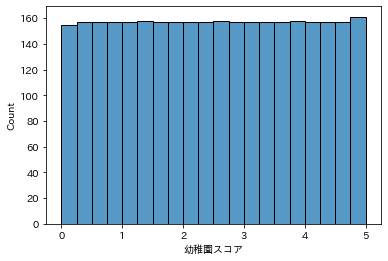

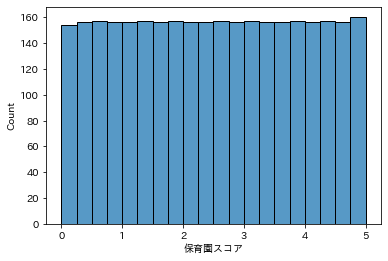

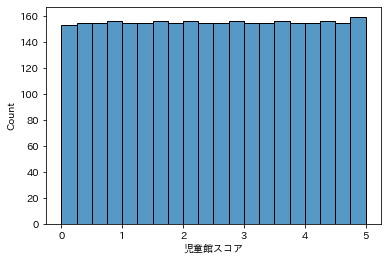

In [15]:
for feature_name in feature_list.keys():
    sns.histplot(df_geo_master[feature_name], bins=20)
    plt.show()

In [16]:
score_list = []
for key, value in feature_list.items():
    df_geo_master[f'{key}レベル'] = rank_score(df_geo_master[key] * value['sort'])
    score_list.append(df_geo_master[f'{key}レベル'] * value['weight'])

_tmp_score = pd.concat(score_list, axis=1).sum(axis=1, skipna=False)
df_geo_master[score_name] = rank_score(_tmp_score)

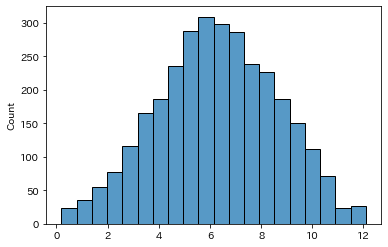

In [17]:
sns.histplot(_tmp_score, bins=20)
plt.show()

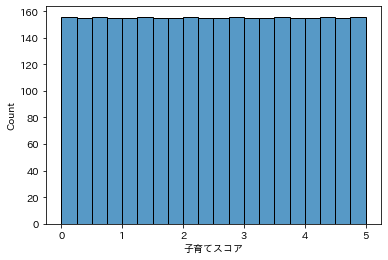

In [18]:
sns.histplot(df_geo_master[score_name], bins=20)
plt.show()

In [19]:
df_geo_master[score_name].describe()

count    3108.000000
mean        2.500000
std         1.444072
min         0.000000
25%         1.250000
50%         2.500000
75%         3.750000
max         5.000000
Name: 子育てスコア, dtype: float64

In [20]:
output_score_list = list(feature_list.keys()) + [score_name]
for col in output_score_list:
    df_geo_master[col] = df_geo_master[col].round(2)

In [21]:
df_geo_master[output_score_list].to_csv(os.path.join(DIR_NAME, output_score_file), index=True, encoding='utf-8_sig')

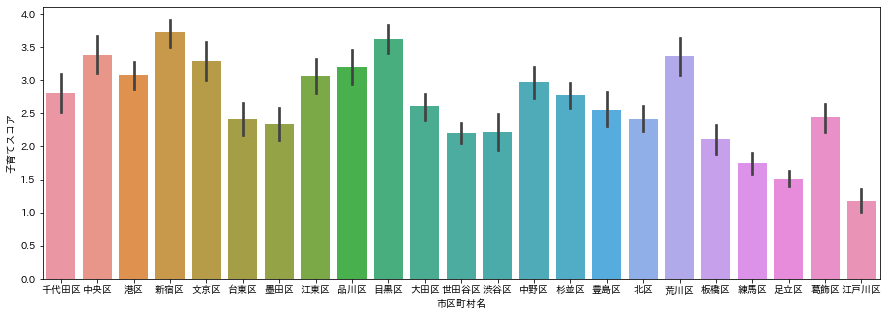

In [22]:
plt.figure(figsize=(15, 5))
sns.barplot(x='市区町村名', y=score_name, data=df_geo_master)
plt.show()

In [23]:
df_level = df_geo_master.copy()
df_level['rank'] = df_level.groupby('町名')[score_name].transform('rank', ascending=False)
df_level = df_level[df_level['rank'] == 1].sort_values(score_name, ascending=False)[
    ['市区町村名', '町名', '町丁目'] + list(feature_list.keys()) + [score_name]
].reset_index(drop=True)
print(df_level.shape)

(901, 7)


In [24]:
df_level.head(10)

,市区町村名,町名,町丁目,幼稚園スコア,保育園スコア,児童館スコア,子育てスコア
0,目黒区,祐天寺,祐天寺２丁目,4.83,4.88,4.76,5.00
1,港区,浜松町,浜松町１丁目,4.91,4.76,4.74,5.00
2,新宿区,東五軒町,東五軒町,4.45,4.97,5.00,5.00
3,千代田区,四番町,四番町,4.75,4.63,4.98,5.00
4,中央区,日本橋小舟町,日本橋小舟町,4.65,4.96,4.64,4.99
5,新宿区,北山伏町,北山伏町,4.43,4.78,4.97,4.99
6,中央区,日本橋堀留町,日本橋堀留町１丁目,4.62,4.98,4.59,4.99
7,新宿区,西五軒町,西五軒町,4.61,4.70,4.91,4.99
8,新宿区,南山伏町,南山伏町,4.31,4.96,4.90,4.99
9,品川区,西大井,西大井６丁目,4.67,4.68,4.95,4.99


In [25]:
df_level.tail(10)

,市区町村名,町名,町丁目,幼稚園スコア,保育園スコア,児童館スコア,子育てスコア
891,世田谷区,駒沢公園,駒沢公園,0.47,0.74,0.63,0.12
892,大田区,昭和島,昭和島１丁目,0.78,0.18,0.92,0.11
893,江戸川区,興宮町,興宮町,0.09,0.70,0.76,0.09
894,世田谷区,砧公園,砧公園,0.87,0.21,0.41,0.06
895,練馬区,立野町,立野町,0.74,0.35,0.40,0.06
896,大田区,京浜島,京浜島１丁目,0.67,0.06,0.08,0.03
897,江東区,新木場,新木場１丁目,0.64,0.04,0.04,0.02
898,江東区,夢の島,夢の島１丁目,0.48,0.07,0.13,0.02
899,江戸川区,南葛西,南葛西１丁目,0.06,0.45,0.01,0.02
900,大田区,東海,東海１丁目,0.24,0.05,0.07,0.01
